# Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
from itertools import cycle
from statsmodels.tsa.stattools import acf, adfuller
from scipy.signal import correlate
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set(font_scale=1)
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
sns.set_style('whitegrid')

# Data Analysis of Bit Coin

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Path = '/content/drive/MyDrive/Colab Notebooks/crypto price prediction/data/raw_stocks/'

## Read Bitcoin Data

In [5]:
btc_data = pd.read_csv(Path+'bitcoin_data.csv',parse_dates=['Date'])
btc_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0


### Drop the unecessary Columns

In [6]:
btc_data = btc_data.drop(['Dividends', 'Stock Splits'], axis =1)
btc_data.head()

,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [7]:
# the function takes dataframe as input and returns number of days present, number of fields present, Starting Date, Ending Date, Duration 
def DataframeDetails(dataFrame):
    print('Total number of days present in the dataset: ',dataFrame.shape[0])
    print('Total number of fields present in the dataset: ',dataFrame.shape[1])
    print('\n')
    sd=dataFrame.iloc[0][0]
    ed=dataFrame.iloc[-1][0]
    print('Starting Date',sd)
    print('Ending Date',ed)
    print("Duration: ", dataFrame.iloc[-1][0]-dataFrame.iloc[0][0])
    print('\n')
    print(dataFrame.info())
    print(dataFrame.describe())
    


In [8]:
DataframeDetails(btc_data)

Total number of days present in the dataset:  2929
Total number of fields present in the dataset:  6


Starting Date 2014-09-17 00:00:00
Ending Date 2022-09-23 00:00:00
Duration:  2928 days 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2929 non-null   datetime64[ns]
 1   Open    2929 non-null   float64       
 2   High    2929 non-null   float64       
 3   Low     2929 non-null   float64       
 4   Close   2929 non-null   float64       
 5   Volume  2929 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 137.4 KB
None
               Open          High           Low         Close        Volume
count   2929.000000   2929.000000   2929.000000   2929.000000  2.929000e+03
mean   12678.490964  13005.411292  12312.912255  12683.382863  1.586744e+10
std    16429.171306  16851.970261  15

In [9]:
# the function takes dataframe as input and finds out missing value percentage for each column
def PercentageOfMissingValues(dataFrame):
    percent_missing = dataFrame.isnull().sum() * 100 / len(dataFrame)
    missing_value_df = pd.DataFrame({'column_name': dataFrame.columns,
                                 'percent_missing': percent_missing})
    return missing_value_df

In [10]:
PercentageOfMissingValues(btc_data)

,column_name,percent_missing
Date,Date,0.0
Open,Open,0.0
High,High,0.0
Low,Low,0.0
Close,Close,0.0
Volume,Volume,0.0


## Exploratory Data Analysis of Bit coin

First let us plot the closing and open value of Bitcoin and observe how the price has changed over time.

In [11]:
def MonthWiseData(dataFrame):
    dataFrame['Date'] = pd.to_datetime(dataFrame['Date'], format='%Y-%m-%d')

    y_overall = dataFrame.loc[(dataFrame['Date'] >= '2014-09-17')
                     & (dataFrame['Date'] <= '2022-09-23')]

    y_overall.drop(y_overall[['Volume']],axis=1)

    monthvise= y_overall.groupby(y_overall['Date'].dt.strftime('%B'))[['Open','Close']].mean()
    new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
    monthvise = monthvise.reindex(new_order, axis=0)
    return y_overall, monthvise

In [12]:
overall, monthvise = MonthWiseData(btc_data)
print(overall, monthvise)

           Date          Open          High           Low         Close  \
0    2014-09-17    465.864014    468.174011    452.421997    457.334015   
1    2014-09-18    456.859985    456.859985    413.104004    424.440002   
2    2014-09-19    424.102997    427.834991    384.532013    394.795990   
3    2014-09-20    394.673004    423.295990    389.882996    408.903992   
4    2014-09-21    408.084991    412.425995    393.181000    398.821014   
...         ...           ...           ...           ...           ...   
2924 2022-09-19  19418.572266  19639.480469  18390.318359  19544.128906   
2925 2022-09-20  19545.591797  19602.457031  18813.455078  18890.789062   
2926 2022-09-21  18891.283203  19674.630859  18290.314453  18547.400391   
2927 2022-09-22  18534.650391  19456.910156  18415.591797  19413.550781   
2928 2022-09-23  19432.929688  19432.929688  19269.771484  19382.259766   

           Volume  
0        21056800  
1        34483200  
2        37919700  
3        36863600  

In [13]:
def PlotMonthlyPrice(dataFrame, title):

    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=dataFrame.index,
        y=dataFrame['Open'],
        name=title+' Open Price',
        marker_color='crimson'
    ))
    fig.add_trace(go.Bar(
        x=dataFrame.index,
        y=dataFrame['Close'],
        name=title+' Close Price',
        marker_color='lightsalmon'
    ))

    fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between average Stock open and close price')
    fig.show()

In [14]:
PlotMonthlyPrice(monthvise, 'Bitcoin')

In [15]:
def StockAnalysis(dataFrame, title):
    names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

    fig = px.line(dataFrame, x=dataFrame.Date, y=[dataFrame['Open'], dataFrame['Close'], 
                                                  dataFrame['High'], dataFrame['Low']],
                  labels={'Date': 'Date','value':'Stock value'})
    fig.update_layout(title_text=title+' stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
    fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

In [16]:
StockAnalysis(overall, 'Bitcoin')

# Etherium Data Analysis

In [ ]:
eth_data = pd.read_csv(Path+'etherium_data.csv',parse_dates=['Date'])
eth_data = eth_data.drop(['Dividends', 'Stock Splits'], axis =1)
eth_data.head()

,Date,Open,High,Low,Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984


In [ ]:
DataframeDetails(eth_data)

Total number of days present in the dataset:  1780
Total number of fields present in the dataset:  6


Starting Date 2017-11-09 00:00:00
Ending Date 2022-09-23 00:00:00
Duration:  1779 days 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1780 non-null   datetime64[ns]
 1   Open    1780 non-null   float64       
 2   High    1780 non-null   float64       
 3   Low     1780 non-null   float64       
 4   Close   1780 non-null   float64       
 5   Volume  1780 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 83.6 KB
None
              Open         High          Low        Close        Volume
count  1780.000000  1780.000000  1780.000000  1780.000000  1.780000e+03
mean   1119.967796  1156.817647  1077.932584  1120.301308  1.301589e+10
std    1220.116242  1257.489434  1176.773032  1219

In [ ]:
overall, monthvise = MonthWiseData(eth_data)

In [ ]:
PlotMonthlyPrice(monthvise, 'etherium')

In [ ]:
StockAnalysis(overall, 'Etherium')

# Lit coin Data Analysis

In [ ]:
lit_data = pd.read_csv(Path+'litcoin_data.csv',parse_dates=['Date'])
lit_data = lit_data.drop(['Dividends', 'Stock Splits'], axis =1)
lit_data.head()

,Date,Open,High,Low,Close,Volume
0,2014-09-17,5.08589,5.17077,4.96595,5.05855,3071840
1,2014-09-18,5.06543,5.06543,4.57996,4.68523,4569260
2,2014-09-19,4.68729,4.75582,4.25435,4.32777,3917450
3,2014-09-20,4.32920,4.61608,4.20219,4.28644,5490660
4,2014-09-21,4.26307,4.30013,4.15499,4.24592,2931220


In [ ]:
DataframeDetails(lit_data)

Total number of days present in the dataset:  2929
Total number of fields present in the dataset:  6


Starting Date 2014-09-17 00:00:00
Ending Date 2022-09-23 00:00:00
Duration:  2928 days 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2929 non-null   datetime64[ns]
 1   Open    2929 non-null   float64       
 2   High    2929 non-null   float64       
 3   Low     2929 non-null   float64       
 4   Close   2929 non-null   float64       
 5   Volume  2929 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 137.4 KB
None
              Open         High          Low        Close        Volume
count  2929.000000  2929.000000  2929.000000  2929.000000  2.929000e+03
mean     67.095361    69.759377    64.176074    67.092743  1.517347e+09
std      68.625761    72.041230    64.838997    6

In [ ]:
overall, monthvise = MonthWiseData(lit_data)

In [ ]:
PlotMonthlyPrice(monthvise, 'Lit coin')

In [ ]:
StockAnalysis(overall, 'Lit coin')

# BNB Coin Data Analysis

In [ ]:
bnb_data = pd.read_csv(Path+'BNB_Coin_data.csv',parse_dates=['Date'])
bnb_data = bnb_data.drop(['Dividends', 'Stock Splits'], axis =1)
bnb_data.head()

,Date,Open,High,Low,Close,Volume
0,2017-11-09,2.05314,2.17423,1.89394,1.99077,19192200
1,2017-11-10,2.00773,2.06947,1.64478,1.79684,11155000
2,2017-11-11,1.78628,1.91775,1.61429,1.67047,8178150
3,2017-11-12,1.66889,1.67280,1.46256,1.51969,15298700
4,2017-11-13,1.52601,1.73502,1.51760,1.68662,12238800


In [ ]:
DataframeDetails(bnb_data)

Total number of days present in the dataset:  1780
Total number of fields present in the dataset:  6


Starting Date 2017-11-09 00:00:00
Ending Date 2022-09-23 00:00:00
Duration:  1779 days 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1780 non-null   datetime64[ns]
 1   Open    1780 non-null   float64       
 2   High    1780 non-null   float64       
 3   Low     1780 non-null   float64       
 4   Close   1780 non-null   float64       
 5   Volume  1780 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 83.6 KB
None
              Open         High          Low        Close        Volume
count  1780.000000  1780.000000  1780.000000  1780.000000  1.780000e+03
mean    139.252830   144.074866   133.965427   139.372698  9.664445e+08
std     185.038433   191.216652   178.057757   184

In [ ]:
overall, monthvise = MonthWiseData(bnb_data)

In [ ]:
PlotMonthlyPrice(monthvise, 'BNB Coin')

In [ ]:
StockAnalysis(overall, 'BNB Coin')

# Overall Data Analysis over Bit, etherium, tethar,and BNB coin

In [17]:
crypto = {}

crypto['bitcoin'] = btc_data
# crypto['ethereum'] = eth_data
# crypto['lit coin'] = lit_data
# crypto['bnb coin'] = bnb_data

In [18]:
# For this analysis I will only be looking at closing price to make things more manageable
for coin in crypto:
    for column in crypto[coin].columns:
        if column not in ['Date', 'Close']:
            crypto[coin] = crypto[coin].drop(column, axis=1)
    # Make date the datetime type and reindex
    crypto[coin]['Date'] = pd.to_datetime(crypto[coin]['Date'])
    crypto[coin] = crypto[coin].sort_values('Date')
    crypto[coin] = crypto[coin].set_index(crypto[coin]['Date'])
    crypto[coin] = crypto[coin].drop('Date', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [19]:
for coin in crypto:
    print(coin, len(crypto[coin]))

bitcoin 2929


In [20]:
# Differencing
for coin in crypto:
    crypto[coin]['CloseDiff'] = crypto[coin]['Close'].diff().fillna(0)

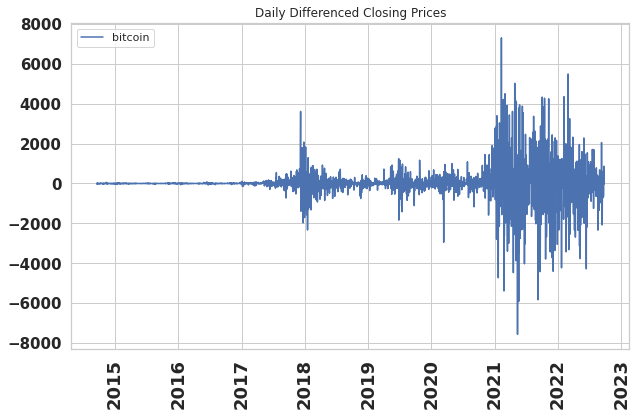

In [21]:
plt.figure(figsize=(10,6))
for coin in crypto:
    plt.plot(crypto[coin]['CloseDiff'], label=coin)

plt.xticks( rotation=0, weight = 'bold', )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=15)
plt.tick_params(rotation=90,axis='x', labelsize=18)
plt.legend(loc=2)
plt.title('Daily Differenced Closing Prices')
plt.show()

Here we see that one of the coins (bitcoin) has much larger spikes than the other coins. While this may still have given us stationarity, it may be useful to also look at the percentage change per day of the timeseries.

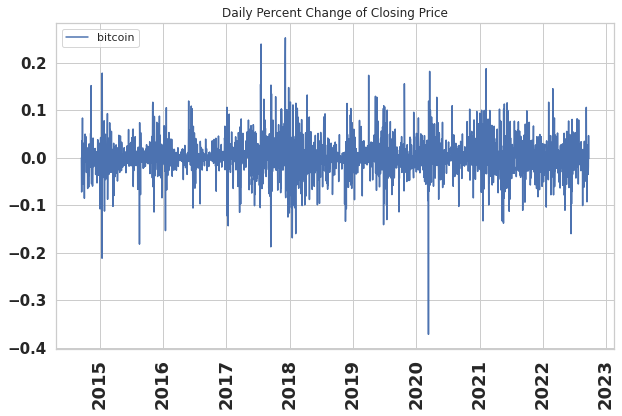

In [22]:
# Percent Change
for coin in crypto:
    crypto[coin]['ClosePctChg'] = crypto[coin]['Close'].pct_change().fillna(0)


plt.figure(figsize=(10,6))
for coin in crypto:
    plt.plot(crypto[coin]['ClosePctChg'], label=coin)

plt.xticks( rotation=0, weight = 'bold', )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=15)
plt.tick_params(rotation=90,axis='x', labelsize=18)
plt.legend(loc=2)
plt.title('Daily Percent Change of Closing Price')
plt.show()

As before, we still have some very large peaks, but overall the data looks more contained than previously. Most importantly, we do not have a single coin dominating the others.

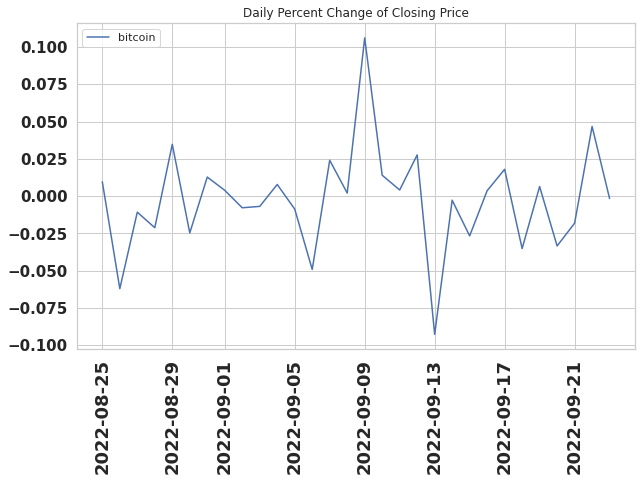

In [24]:
plt.figure(figsize=(10,6))
for coin in crypto:
    plt.plot(crypto[coin]['ClosePctChg'][-30:], label=coin)
plt.xticks( rotation=0, weight = 'bold', )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=15)
plt.tick_params(rotation=90,axis='x', labelsize=18)
plt.legend(loc=2)
plt.title('Daily Percent Change of Closing Price')
plt.show()

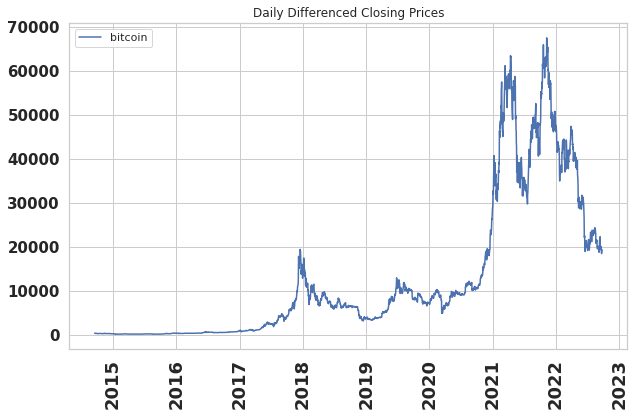

In [25]:
plt.figure(figsize=(10,6))
for coin in crypto:
    plt.plot(crypto[coin]['Close'], label=coin)

plt.xticks( rotation=0, weight = 'bold', )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=15)
plt.tick_params(rotation=90,axis='x', labelsize=18)
plt.legend(loc=2)
plt.title('Daily Differenced Closing Prices')
plt.show()

In [26]:
for coin in crypto:
    print('\n',coin)
    adf = adfuller(crypto[coin]['ClosePctChg'][1:])
    print(coin, 'ADF Statistic: %f' % adf[0])
    print(coin, 'p-value: %f' % adf[1])
    print(coin, 'Critical Values', adf[4]['1%'])
    print(adf)


 bitcoin
bitcoin ADF Statistic: -55.198225
bitcoin p-value: 0.000000
bitcoin Critical Values -3.4325860929804404
(-55.19822473783658, 0.0, 0, 2927, {'1%': -3.4325860929804404, '5%': -2.8625279573644873, '10%': -2.5672959172141048}, -10632.688651121116)


In [ ]:
for coin in crypto:
    print('\n',coin)
    adf = adfuller(crypto[coin]['CloseDiff'][1:])
    print(coin, 'ADF Statistic: %f' % adf[0])
    print(coin, 'p-value: %f' % adf[1])
    print(coin, 'Critical Values', adf[4]['1%'])
    print(adf)


 bitcoin
bitcoin ADF Statistic: -8.997083
bitcoin p-value: 0.000000
bitcoin Critical Values -3.4326077094598446
(-8.997083119579205, 6.6497824882673215e-15, 28, 2899, {'1%': -3.4326077094598446, '5%': -2.862537504404245, '10%': -2.5673009999844125}, 46964.68818177582)

 ethereum
ethereum ADF Statistic: -10.452602
ethereum p-value: 0.000000
ethereum Critical Values -3.4340667152437305
(-10.452602427307669, 1.4253473419293017e-18, 16, 1762, {'1%': -3.4340667152437305, '5%': -2.8631817229557326, '10%': -2.5676440035250416}, 20345.262021983526)

 lit coin
lit coin ADF Statistic: -10.357996
lit coin p-value: 0.000000
lit coin Critical Values -3.4326077094598446
(-10.357996298119271, 2.4379830769129613e-18, 28, 2899, {'1%': -3.4326077094598446, '5%': -2.862537504404245, '10%': -2.5673009999844125}, 19115.676161772535)

 bnb coin
bnb coin ADF Statistic: -7.806791
bnb coin p-value: 0.000000
bnb coin Critical Values -3.434083692100666
(-7.806790603280807, 7.245695366115831e-12, 24, 1754, {'1%'

Here we see that our data is very stationary! This is clear because of the extremely low p-values..

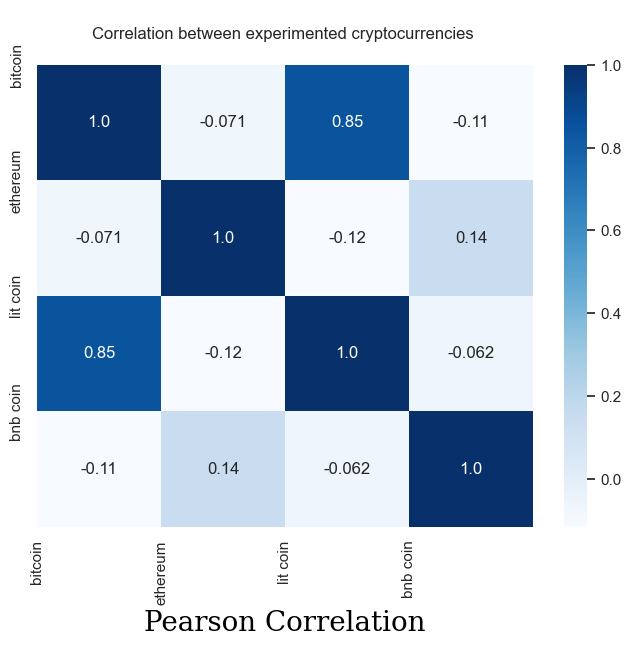

In [ ]:
corrBitcoin = {}
corrDF = pd.DataFrame()

for coin in crypto: 
    corrBitcoin[coin] = correlate(crypto[coin]['ClosePctChg'], crypto['bitcoin']['ClosePctChg'])
    lag = np.argmax(corrBitcoin[coin])
    laggedCoin = np.roll(crypto[coin]['ClosePctChg'], shift=int(np.ceil(lag)))
    # 👇️ replace None values in a list with 0
    laggedCoin = [0 if i is None else i for i in laggedCoin]
    corrDF[coin] = laggedCoin[:40]

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

# plt.matshow(corrDF.corr(method='pearson'))
fig, ax = plt.subplots(figsize=(8,6))
heatmap = corrDF.corr(method='pearson')
sns.heatmap(heatmap, cmap= "Blues", annot=True, ax=ax, fmt=".2")
plt.title('\n''Correlation between experimented cryptocurrencies \n')
plt.xticks( range(4),corrDF.columns, rotation='vertical')
plt.yticks( range(4),corrDF.columns)
plt.xlabel('Pearson Correlation', fontdict=font)
plt.show()
